In [2]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! git checkout error_bars
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(my_utils)
importlib.reload(utils)
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


Cloning into 'hetvae'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 486 (delta 19), reused 13 (delta 7), pack-reused 448
Receiving objects: 100% (486/486), 20.47 MiB | 32.25 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Branch 'error_bars' set up to track remote branch 'error_bars' from 'origin'.
Switched to a new branch 'error_bars'


##Pick your poison:

In [3]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#-------------------------------
agn_file = '/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv'
agn_df = pd.read_csv(agn_file)
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)


In [ ]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]
lcs,max_len = my_utils.file_to_np(*(lc_files*100))
lcs = lcs[:64]

## Data augmentation

In [4]:
new_samples = (lcs * 10).copy()
for lc in new_samples:
    lc = my_utils.resample_lc(lc)

lcs.extend(new_samples) 

lcs is now a python list of numpy array lcs 


In [5]:
lcs, starts, max_len = my_utils.zero_start(lcs)
lcs = my_utils.handle_dups(lcs)
union_tp = my_utils.union_timepoints(lcs)
print(len(union_tp))
lcs = my_utils.include_union_tp(lcs, max_len)
lcs.shape

2423


(55, 621, 3)

(55,)

In [8]:

#----------------------------------------------------------------------------------------------------------
# NORMALIZING
#----------------------------------------------------------------------------------------------------------
std_time = np.std(union_tp)
#std_flux = np.std(lcs[:,:,1].flatten())
#mean_flux = np.mean(lcs[:,:,1].flatten())
union_tp = union_tp / std_time
lcs[:,:,0] = lcs[:,:,0] / std_time

# normalize flux for light curves individually
stds = np.zeros((len(lcs)))
# ---------> keep stds for later? 
for i,lc in enumerate(lcs):
    flux_std = np.std(lc[:,1])
    lc[:,1] = lc[:,1] / flux_std
    # how are we going to normalize error bars? by flux std?
    lc[:,2] = lc[:,2] / flux_std
    stds[i] = flux_std


# ----------------------------------------------------------------------------------------------------------
lcs = lcs.astype(np.float32)
union_tp = union_tp.astype(np.float32)
union_tp = torch.tensor(union_tp)

#-----------------------------------------------------------------------------------------------------------
#MASKS
#-----------------------------------------------------------------------------------------------------------

smask, rmask = my_utils.make_masks(lcs, frac=0.5, batch_size=8)
lcs = np.concatenate((lcs, smask[:,:,np.newaxis], rmask[:,:,np.newaxis]), axis=-1)

In [9]:
train_loader = torch.utils.data.DataLoader(lcs, batch_size=8)
dim = 1


## Setting up arguments

In [10]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [11]:
# num heads?
args = Namespace(batch_size=8, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=256, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.000001, mixing='concat', mse_weight=0.0, n=256, net='hetvae', 
                 niters=1000, norm=False, normalize_input='znorm', num_ref_points=128, rec_hidden=128, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=1024)

In [12]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Generating Synthetic Data**

In [ ]:

# dataset class that loads agn by folder you give it? agn object, agn.addLC('').addLC('')
# kl negative? negative losses in general???
# fixing visualization
# different sequence sizes, some drastically shorter... how to make this not matter? does it? --> standardize how many points we take in ?
# what is their normalization=True doing? ->dividing by the sum of the masks? 
# think about removing outliers in preprocessing
# 


# agenda
  # fixing visualization
  # removing outliers in preprocessing
  # improving learning rate stuff

## **Loading HeTVAE model**

In [11]:
net = models.load_network(args, dim, union_tp) # dim = 1
params = list(net.parameters())
optimizer = optim.Adam(params, lr=.00001)
# definitly want a decaying error rate...
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)


## **Training**

In [12]:
def train(net, optimizer,epoch, train_loader):
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]

          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              train_batch[:, :, 1:2] * subsampled_mask, subsampled_mask
          ), -1) 

    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, 0], # context_x, times
              context_y,             # context_y
              train_batch[:, :, 0], # target_x, same times? 
              torch.cat((            # flux values with only recon_mask values showing
                  train_batch[:, :, 1:2] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              error_bars = 0.   # otherwise: train_batch[:,:,2:3] 
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
          
          # if train_loss < 1:
          #   break
      
      # if train_loss <= 5:
      #   return
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      
      
        # no test data yet
    #       for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
    #           utils.evaluate_hetvae(
    #               net,
    #               dim,
    #               loader,
    #               0.5,
    #               shuffle=False,
    #               k_iwae=num_samples,
    #               model_name=args.net,
    #           )


7

In [15]:
for epoch in range(201, 300+1):#args.niters + 1):
    train(net, optimizer, epoch, train_loader)
    scheduler.step()

Iter: 300, train loss: 2.3373, avg nll: -8.6045, avg kl: 10.9418, mse: 0.156334, mae: 0.223176


In [14]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001

1e-05


In [ ]:
torch.save(net, 'weights.pt')

In [ ]:
net = torch.load('weights.pt')

## **Vizualization with increasing number of observations**

In [39]:

def viz(test_loader, net, k_iwae=1, n_max=10, fracs=[0.3,0.6,0.9]):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for frac in fracs: # 
            
            for i, batch in enumerate(test_loader):

                smask, rmask = my_utils.make_masks(batch, frac=frac)
                batch[:,:,3:4] = torch.tensor(smask).unsqueeze(-1)
                batch[:,:,4:5] = torch.tensor(rmask).unsqueeze(-1)

                batch_len = batch.shape[0]
                batch = batch.to(device)
                subsampled_mask = batch[:,:,3:4]

                seqlen = batch.size(1)
                
                context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
                # probabilities per batch?  
                px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy()) # (10,batch_size, seq len,1)


                # changing from logvar to std 
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, 1:2]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, 0].cpu().numpy())
                
                # how many batches of predictions for each frac?

    # 10 samples per light curve, 48 light curves, 621, 1
    # first 16 are frac[0], second 16 are frac[1], 
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    # 5, 48, 621, 1 
     
    # sample from samples? 
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean


    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])

    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.99, axis=0)
    quantile1 = np.quantile(preds, 0.01, axis=0)
    print(preds.shape)
    print("pay attention", quantile1.shape)
    print(preds)
    
    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12.5, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()


In [ ]:
# visualisation for one light curve w/ increasing number of points

def viz_per_lc(lc, net, k_iwae=1, n_max=10, fracs=[0.3,0.6,0.9]): 
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for frac in fracs: # 
            
            smask, rmask = my_utils.make_masks(lc[np.newaxis,:,:], frac=frac)
            batch[:,:,3:4] = torch.tensor(smask).unsqueeze(-1)
            batch[:,:,4:5] = torch.tensor(rmask).unsqueeze(-1)

            batch_len = batch.shape[0]
            batch = batch.to(device)
            subsampled_mask = batch[:,:,3:4]

            seqlen = batch.size(1)
            
            context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
            # probabilities per batch?  
            px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy()) # (10,batch_size, seq len,1)


            # changing from logvar to std 
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            targets.append((batch[:, :, 1:2]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, :, 0].cpu().numpy())
            
                # how many batches of predictions for each frac?

    # 10 samples per light curve, 48 light curves, 621, 1
    # first 16 are frac[0], second 16 are frac[1], 
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    # 5, 48, 621, 1 
     
    # sample from samples? 
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean


    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])

    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.99, axis=0)
    quantile1 = np.quantile(preds, 0.01, axis=0)
    print(preds.shape)
    print("pay attention", quantile1.shape)
    print(preds)
    
    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12.5, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()


(10, 165, 621, 1) (10, 165, 621, 1) (165, 621, 1) (165, 621, 1) (165, 621)
(5, 10, 165, 621, 1) ?
(10, 165, 621, 1)
(50, 165, 621, 1)
pay attention (165, 621, 1)
[[[[-7.75108089e-02]
   [-8.96402499e-01]
   [ 2.97581078e-01]
   ...
   [-5.89931427e-01]
   [-3.31605239e-02]
   [ 6.79966310e-01]]

  [[-2.74534101e-01]
   [-2.77051633e-01]
   [-2.98488120e-01]
   ...
   [-7.04001950e-01]
   [ 4.48437805e-01]
   [-1.08340221e+00]]

  [[-5.22324058e-01]
   [ 1.60603511e-01]
   [-3.24989611e-01]
   ...
   [ 6.20690533e-01]
   [-5.82181219e-01]
   [-3.00358012e-01]]

  ...

  [[ 4.74118465e+00]
   [ 4.96594543e+00]
   [ 4.95371439e+00]
   ...
   [ 5.06184785e+00]
   [ 5.24851978e+00]
   [ 4.82386898e+00]]

  [[ 2.48602735e+00]
   [ 2.85879295e+00]
   [ 2.30704860e+00]
   ...
   [ 2.80745873e+00]
   [ 2.78055341e+00]
   [ 3.05048222e+00]]

  [[ 3.36328568e+00]
   [ 3.77336973e+00]
   [ 3.04673417e+00]
   ...
   [ 3.44834759e+00]
   [ 3.23649659e+00]
   [ 3.52246139e+00]]]


 [[[ 1.47658046e-01

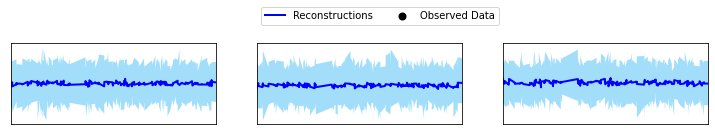

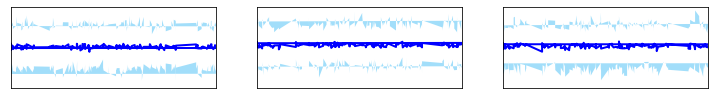

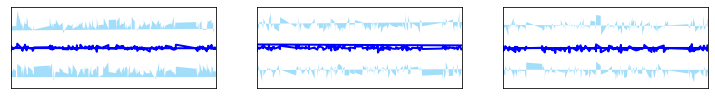

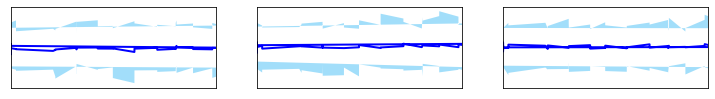

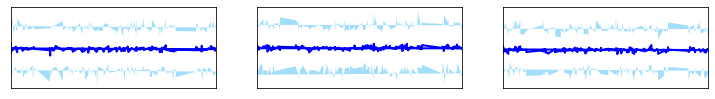

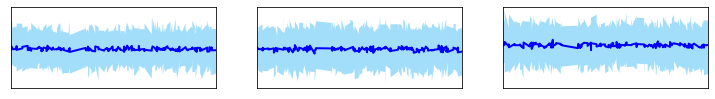

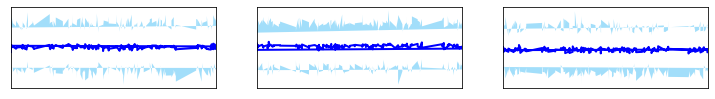

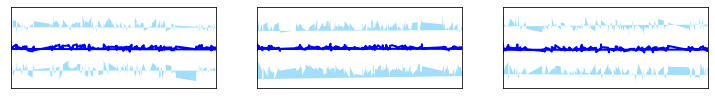

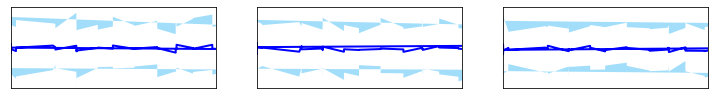

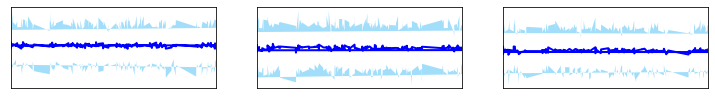

In [41]:
viz(train_loader, net, k_iwae=10)

In [ ]:
def viz(test_loader, net, k_iwae=1, n_max=10, ):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp = []
    np.random.seed(0)
    with torch.no_grad():
        for _ in range(3):
            for i, batch in enumerate(test_loader):
                
                batch_len = batch.shape[0]
                batch = batch.to(device)
                subsampled_mask = batch[:,:,3:4]
                seqlen = batch.size(1)
                context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, 1:2]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, 0].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break

                    
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)


    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.99, axis=0)
    quantile1 = np.quantile(preds, 0.01, axis=0)
    print(preds.shape)
    print("pay attention", quantile1.shape)
    print(preds)
    
    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12.5, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()

(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 48, 621, 1) (10, 48, 621, 1) (48, 621, 1) (48, 621, 1) (48, 621)
(50, 48, 621, 1)
pay attention (48, 621, 1)
[[[[ 9.09027851e-01]
   [ 1.46466796e-01]
   [ 4.69158486e-01]
   ...
   [ 7.29860659e-01]
   [-9.38114953e-01]
   [ 3.64272914e-01]]

  [[-2.69431811e-01]
   [-1.79806794e-01]
   [-2.24539449e-01]
   ...
   [-6.83035487e-01]
   [ 1.26276778e+00]
   [ 8.74045848e-03]]

  [[ 2.46164020e-01]
   [ 1.30924471e-01]
   [ 1.91831819e-01]
   ...
   [-4.52828943e-01]
   [-3.81047257e-01]
   [-3.98608627e-01]]

  ...

  [[ 2.70634397e+00]
   [ 2.62342101e+00]
   [ 2.74485907e+00]
   ...
   [ 2.88627561e+00]
   [ 2.77657158e+00]
   [ 2.59475730e+00]]

  [[ 3.62404972e+00]
   [ 3.59708575e+00]
   [ 3.71453739e+00]
   ...
   [ 3.42863729e+00]
   [ 3.53679498e+00]
   [ 3.41859824e+00]]

  [[ 1.67939029e+01]
   [ 1.73144736e+01]
   [ 1.68208746e+01]
   ...
   [ 1.52949189e+01]
   [ 1.68982334e+

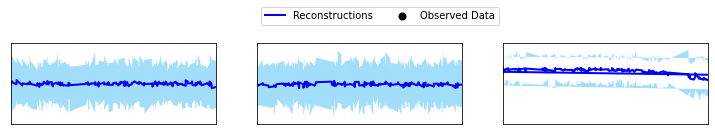

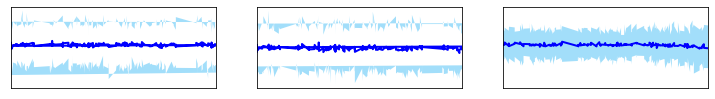

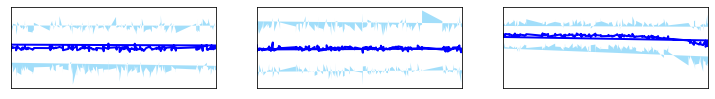

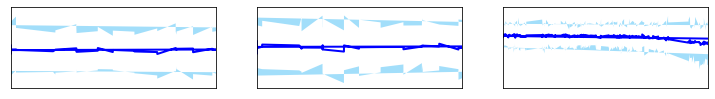

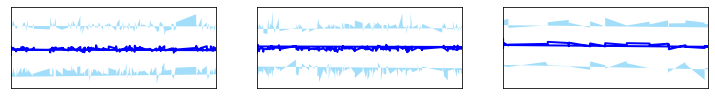

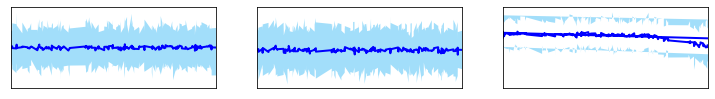

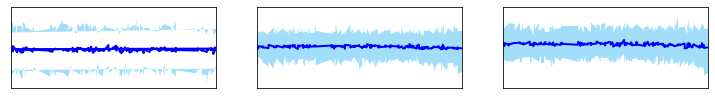

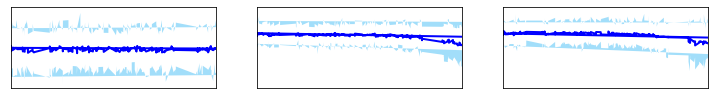

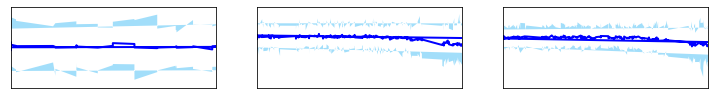

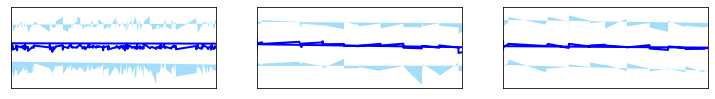

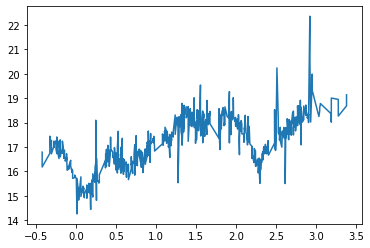

In [ ]:
plt.plot(lcs[0,:,0], lcs[0,:,1])